In [1]:
import numpy as np
import scipy.io as sio
from scipy.stats import entropy
import matplotlib.pyplot as plt

from bmm import BMM
from lda import LDA

import seaborn as sns
sns.set(rc={'figure.figsize':(14,8.27)})
sns.set_palette('colorblind')

In [2]:
np.random.seed(1)
# load data
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])
B = data['B']
V = data['V']

# Exercise A

Using the training data in A, find the maximum likelihood multinomial over words, and show the 20
largest probability items in a histogram. For that multinomial model,
what is the highest and lowest possible test set log probability (for any possible test set)? Explain the
implications of this.

In [3]:
W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])  # total number of unique words
D = np.max(A[:, 0])  # number of documents in A

word_counts = np.zeros(W)
# Populate the count matrices by looping over documents
for d in range(D):
    training_documents = np.where(A[:, 0] == d+1)  # get all occurrences of document d in the training data
    w = np.array(A[training_documents, 1])  # number of unique words in document d
    c = np.array(A[training_documents, 2])  # counts of words in document d
    word_counts[w-1] += c  # number of times w is assigned to component k

In [4]:
no_words = np.sum(word_counts).astype(int)
word_freq = word_counts / no_words

In [5]:
top_20_ids = np.argsort(word_freq)[-20:]
top_20_freq = word_freq[top_20_ids]
top_20_words = [word[0] for word in V[top_20_ids, 0]]

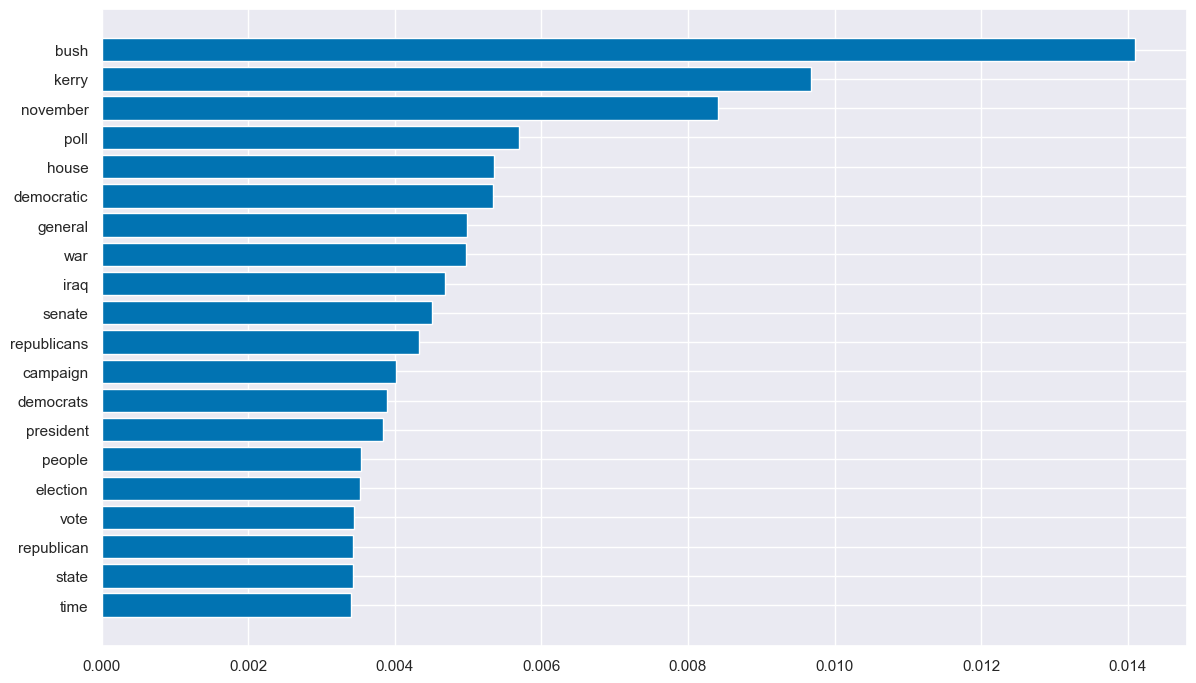

In [6]:
plt.barh(top_20_words, top_20_freq)
plt.show()

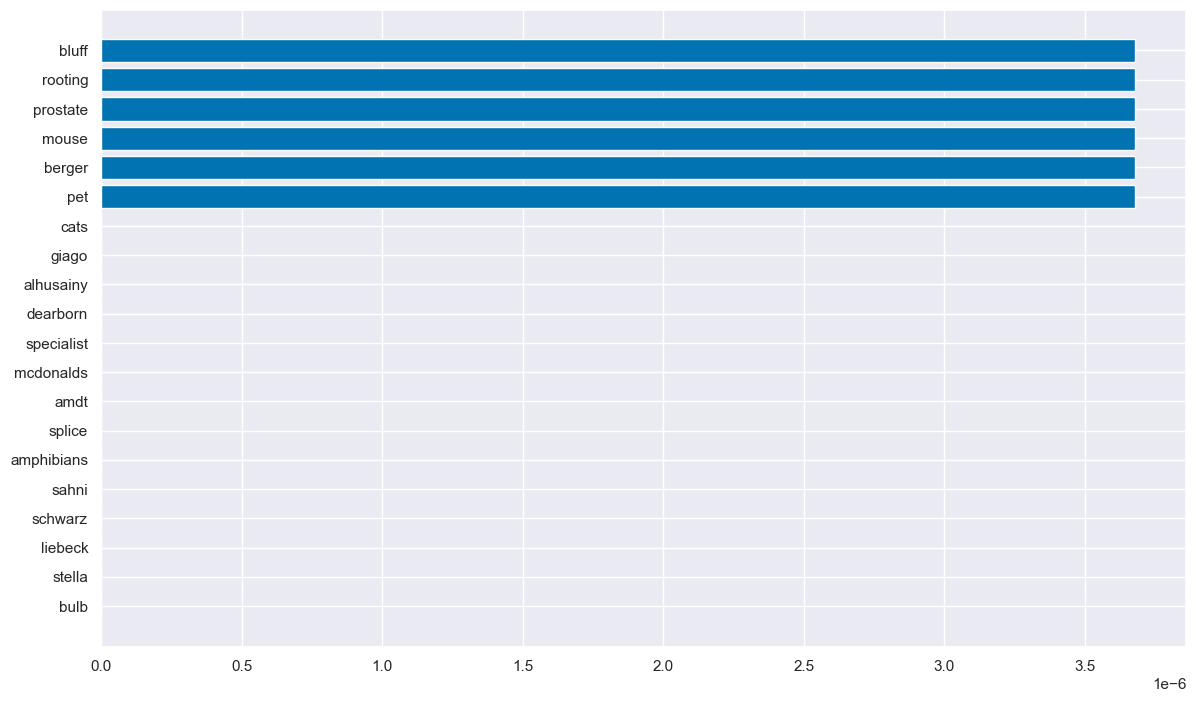

In [7]:
bot_20_ids = np.argsort(word_freq)[:20]
bot_20_freq = word_freq[bot_20_ids]
bot_20_words = [word[0] for word in V[bot_20_ids, 0]]
plt.barh(bot_20_words, bot_20_freq)
plt.show()

# Exercise B

Instead of the maximum likelihood fit in question a), do Bayesian inference using a symmetric Dirichlet
prior with a concentration parameter α on the word probabilities. Compare the expressions for the
predictive word probabilities for these two types of inference, and explain the implications, both for
common and rare words for both small and large values of α.

In [8]:
alpha = 1
pseudo_word_count = alpha * np.ones(W)
print(f'Total pseudo-words added = {np.sum(pseudo_word_count)}')

Total pseudo-words added = 6906.0


In [9]:
posterior_word_counts = word_counts + pseudo_word_count

In [10]:
posterior_no_words = np.sum(posterior_word_counts).astype(int)
posterior_word_freq = posterior_word_counts / np.sum(posterior_word_counts)

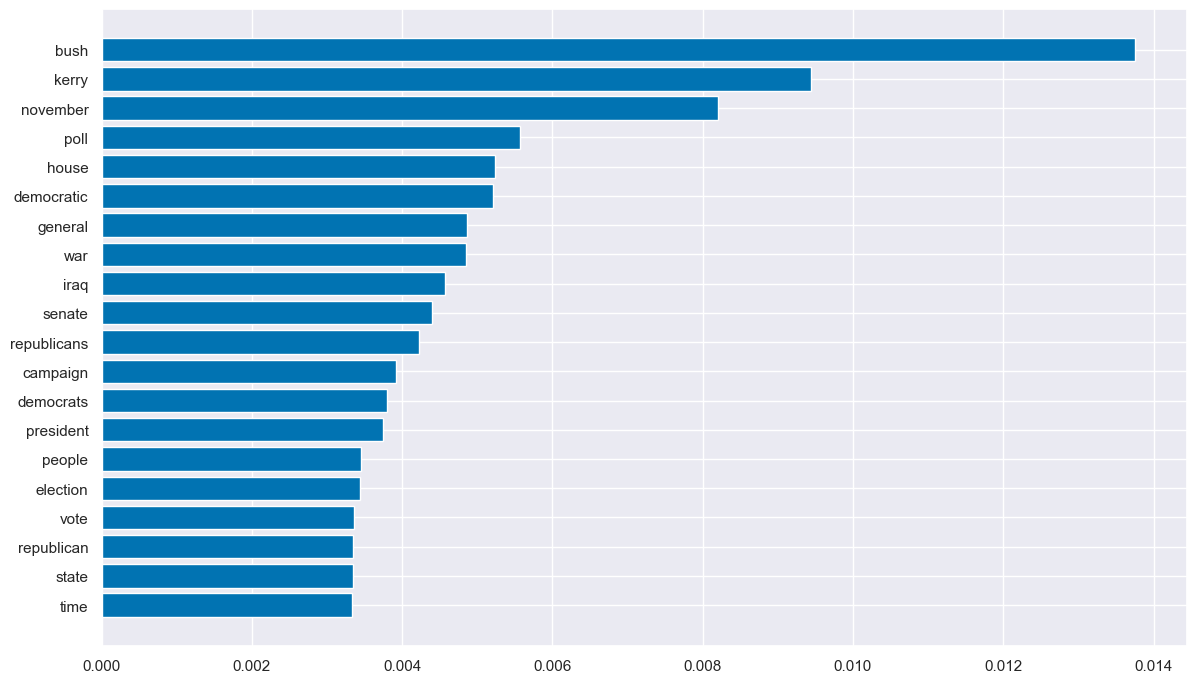

In [11]:
top_20_ids = np.argsort(posterior_word_freq)[-20:]
top_20_freq = posterior_word_freq[top_20_ids]
top_20_words = [word[0] for word in V[top_20_ids, 0]]
plt.barh(top_20_words, top_20_freq)
plt.show()

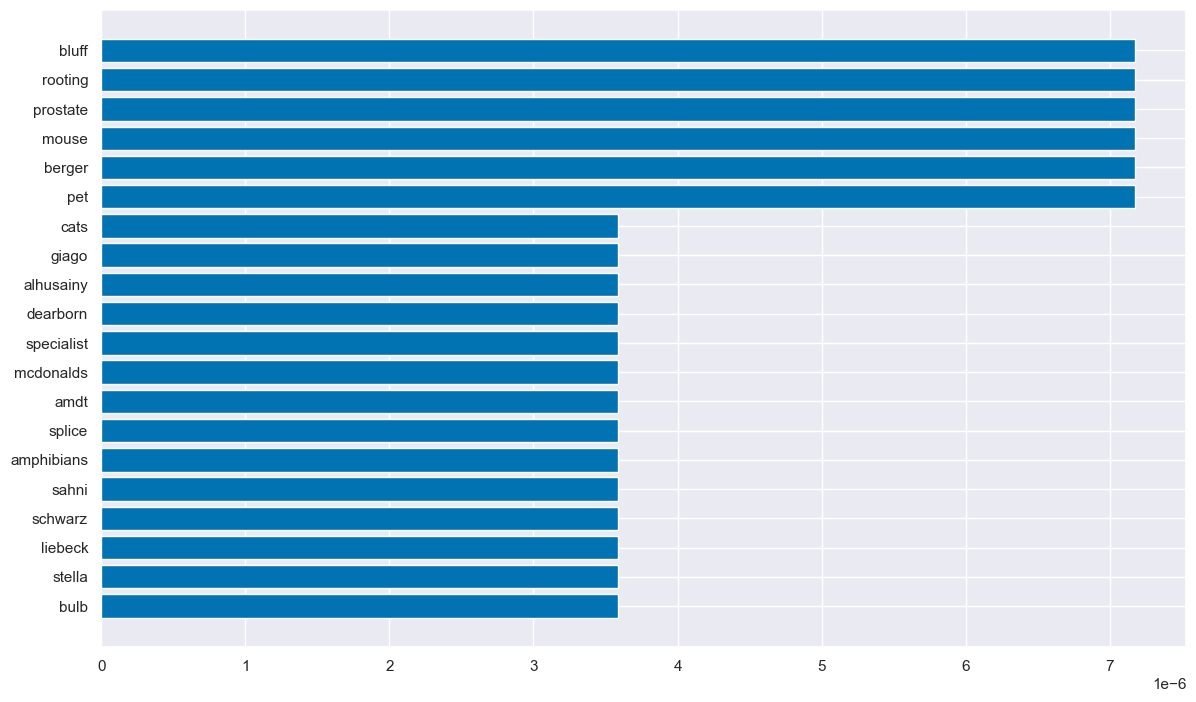

In [12]:
bot_20_ids = np.argsort(posterior_word_freq)[:20]
bot_20_freq = posterior_word_freq[bot_20_ids]
bot_20_words = [word[0] for word in V[bot_20_ids, 0]]
plt.barh(bot_20_words, bot_20_freq)
plt.show()

# Exercise C

For the Bayesian model, what is the log probability for the test document with ID 2001? Explain
whether, when computing the log probability of a test document, you would use the multinomial or
the categorical distribution function? What is the per-word perplexity for the document with ID 2001?
What is the per-word perplexity over all documents in B? Explain why the perplexities are different for
different documents? What would the perplexity be for a uniform multinomial?

In [13]:
word_counts = np.zeros(W)
# Populate the count matrices by looping over documents
test_documents = np.where(B[:, 0] == 2001)  # get all occurrences of document d in the training data
w = np.array(B[test_documents, 1])  # number of unique words in document d
c = np.array(B[test_documents, 2])  # counts of words in document d
word_counts[w-1] += c  # number of times w is assigned to component k

In [14]:
log_prob = np.dot(word_counts, np.log(posterior_word_freq))
print(f'Log Probability of Test 2001 = {log_prob}')
perplexity = np.exp(-log_prob / np.sum(word_counts))
print(f'Per-word Perplexity across Test 2001= {perplexity}')

Log Probability of Test 2001 = -3688.6211698172992
Per-word Perplexity across Test 2001= 4373.110988104844


In [15]:
W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])  # total number of unique words
D = np.max(B[:, 0])  # number of documents in A

word_counts = np.zeros(W)
# Populate the count matrices by looping over documents
for d in range(D):
    training_documents = np.where(B[:, 0] == d+1)  # get all occurrences of document d in the training data
    w = np.array(B[training_documents, 1])  # number of unique words in document d
    c = np.array(B[training_documents, 2])  # counts of words in document d
    word_counts[w-1] += c  # number of times w is assigned to component k
no_words = np.sum(word_counts).astype(int)

In [16]:
log_prob = np.dot(word_counts, np.log(posterior_word_freq))
print(f'Log Probability of the Test Document = {log_prob}')
perplexity = np.exp(-log_prob / no_words)
print(f'Per-word Perplexity across the Test Document= {perplexity}')

Log Probability of the Test Document = -1545978.5917629278
Per-word Perplexity across the Test Document= 2683.9840703508576


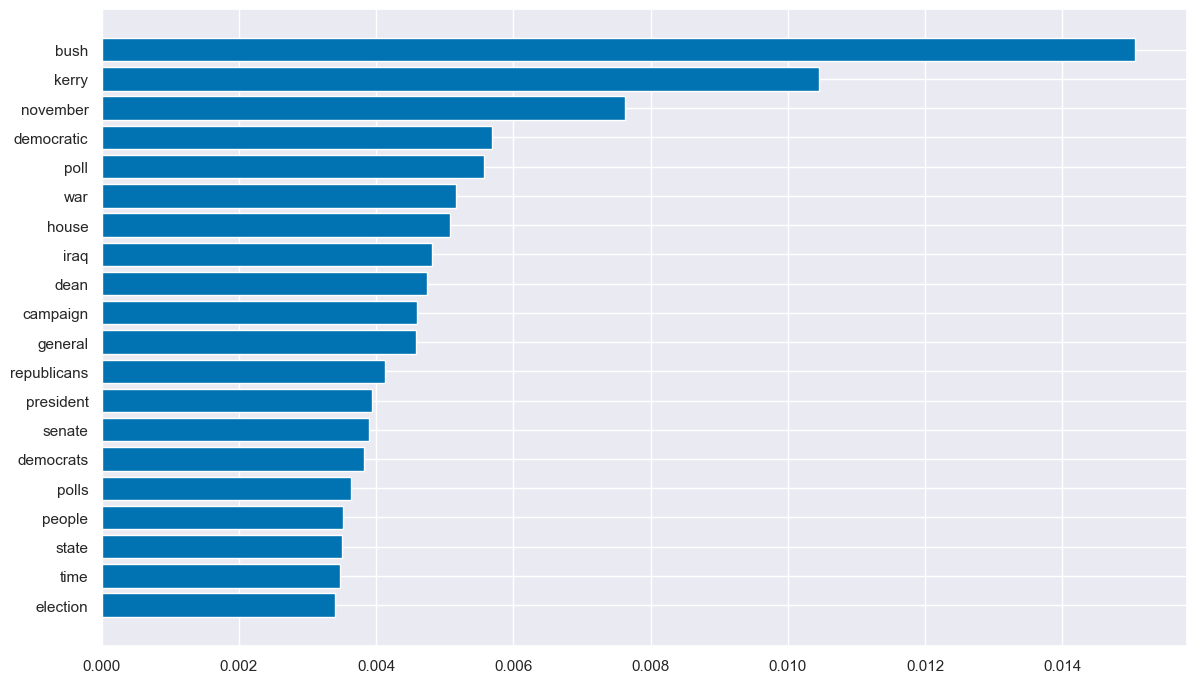

In [17]:
word_freq = word_counts / no_words
top_20_ids = np.argsort(word_freq)[-20:]
top_20_freq = word_freq[top_20_ids]
top_20_words = [word[0] for word in V[top_20_ids, 0]]
plt.barh(top_20_words, top_20_freq)
plt.show()

# Exercise D

The bmm script implements Gibbs sampling for a mixture of multinomials model. Use and modify the
script to plot the evolution of the mixing proportions as a function of the number of Gibbs sweeps
up to 50 iterations. The mixing proportions are the posterior probabilities of each of the mixture
components. Explain carefully, how would you determine whether the Gibbs sampler converges to
and explores the stationary distribution (the posterior), does it?

In [18]:
K = 20  # number of clusters
iterations = 50
alpha = 10  # parameter of the Dirichlet over mixture components
gamma = .1  # parameter of the Dirichlet over words
np.random.seed(42)
perplexity, swk, sk_docs_evolution, sk_words_evolution = BMM(A, B, K, alpha, gamma)

In [19]:
sk_docs_evolution_mixture = sk_docs_evolution / np.sum(sk_docs_evolution[0, :])
sk_words_evolution_mixture = sk_words_evolution / np.sum(sk_words_evolution[0, :])

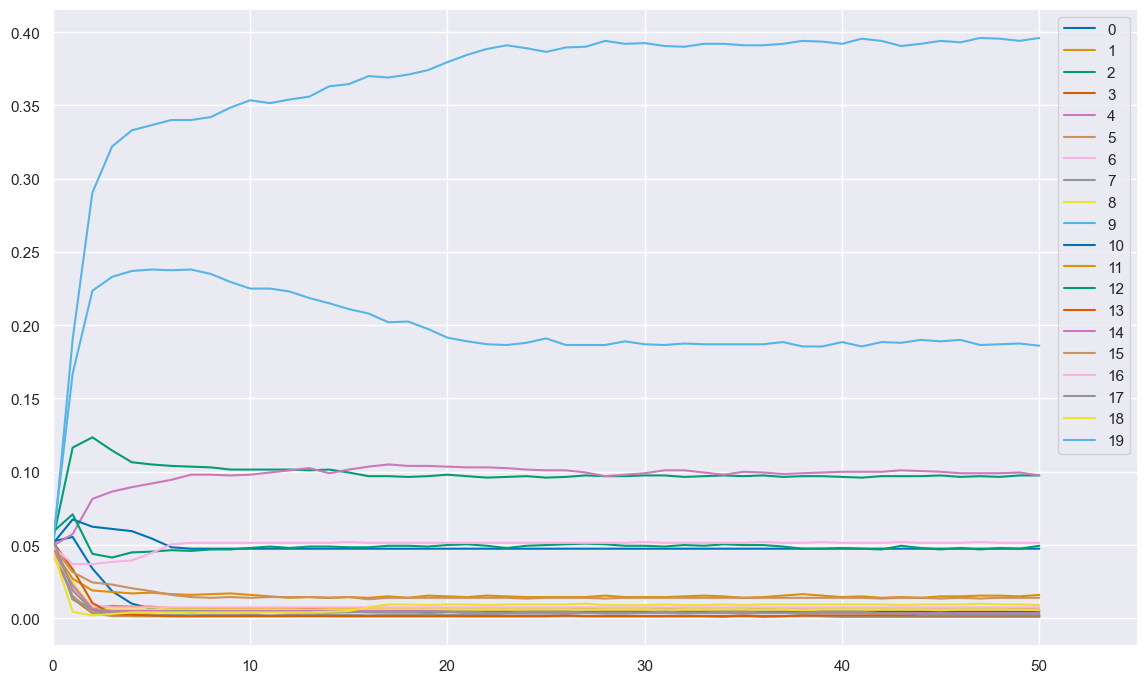

In [20]:
plt.plot(sk_docs_evolution_mixture, label=np.arange(20))
plt.legend()
plt.xlim(0, iterations + 5)
plt.show()

# Exercise E

 Use and modify lda. Plot topic posteriors for K = 20 as a function of the number of Gibbs sweeps, up
to 50 sweeps. Comment on these. Compute the perplexity for the documents in B for the state after
50 Gibbs sweeps, and compare to previously computed perplexities. Are 50 Gibbs sweeps adequate?
Plot the word entropy (what units do you use?) for each of the topics as a function of the number of
Gibbs sweeps. Explain what you see.

In [21]:
K = 20  # number of clusters
iterations = 50
np.random.seed(42)
alpha = 10  # parameter of the Dirichlet over mixture components
gamma = .1  # parameter of the Dirichlet over words
np.random.seed(42)
perplexity, swk, sk_evolution, entropy_evolution = LDA(A, B, K, alpha, gamma)

In [22]:
sk_evolution_mixture = sk_evolution / np.sum(sk_evolution[0, :])

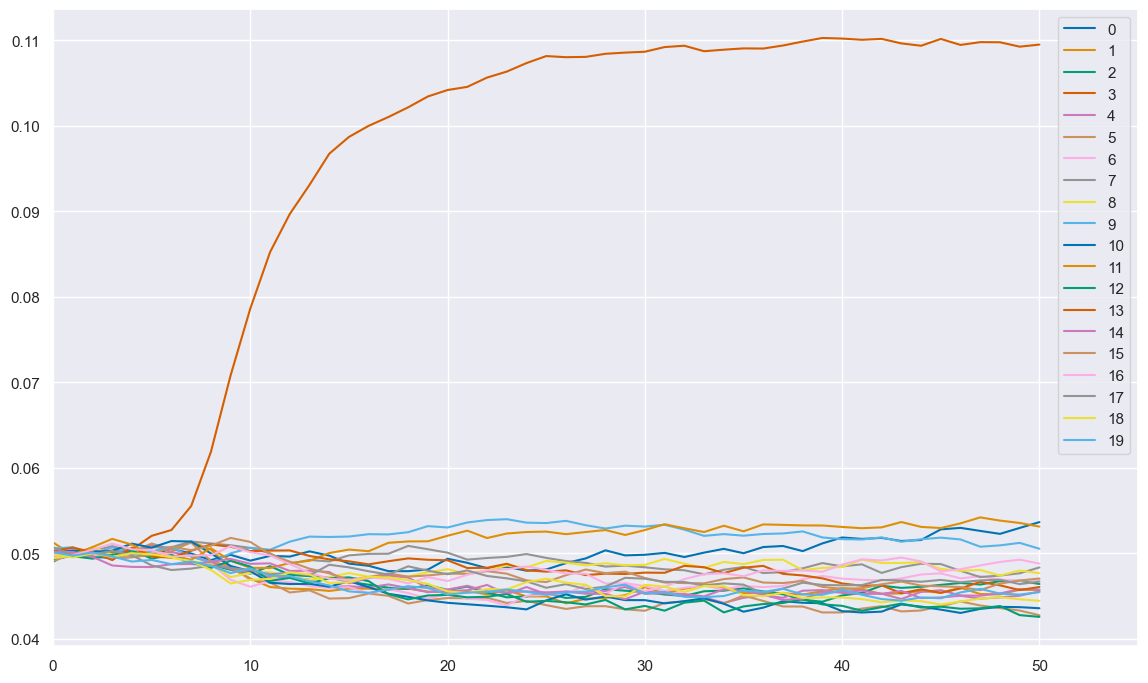

In [23]:
plt.plot(sk_evolution_mixture, label=np.arange(20))
plt.legend()
plt.xlim(0, iterations + 5)
plt.show()

In [24]:
print(perplexity)

[2072.74038823]


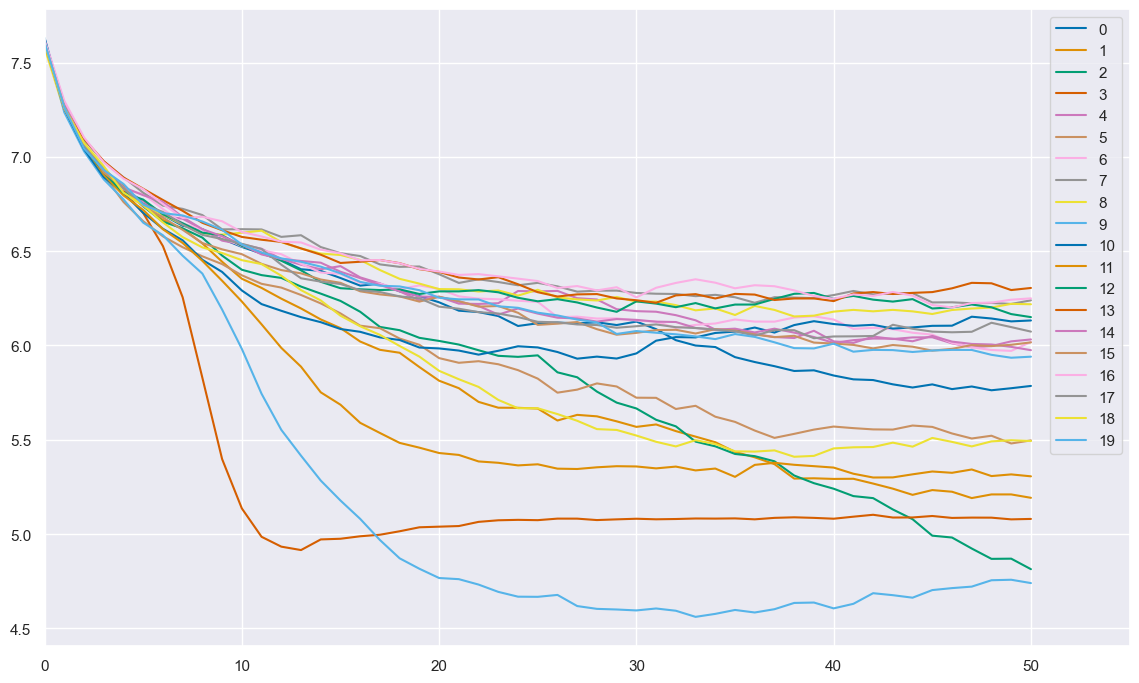

In [25]:
plt.plot(entropy_evolution, label=np.arange(20))
plt.legend()
plt.xlim(0, iterations + 5)
plt.show()